# 02 — Plot Soundings Envelope (Base vs Range)
Plots the **base sounding** as a thick line and the **range (min–max)** of a collection as a fill.
Use either a folder of `input_sounding_*` files or generate analytic soundings on the fly.

In [15]:
import numpy as np
import pickle
import os
import glob
import matplotlib.pyplot as plt
from metpy.units import units
# Import read_input_sounding from your generator file
from sounding_generator import read_input_sounding 
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import sys
# --- CONFIGURATION (Adjust Paths as needed) ---


REPO_ROOT = Path.cwd().parents[0] if (Path.cwd().name == 'notebooks') else Path.cwd()
SRC = REPO_ROOT / 'src'
sys.path.insert(0, str(SRC))
EXPERIMENT_DIR = str(REPO_ROOT / 'outputs' / 'sobol_exp_500')
BASE_SOUNDING = str(SRC / 'input_sounding')  # Your base sounding file
N_SAMPLES = 500  # How many samples to generate (for testing)

# For 'folder' mode: directory with input_sounding_* files
SOUNDINGS_DIR = str(REPO_ROOT / 'outputs' / 'sobol_exp_500' / 'soundings')

# For 'diagnostics' mode: path to diagnostics.pkl from step2
DIAGNOSTICS_FILE = str(REPO_ROOT / 'outputs' / 'sobol_exp_500' / 'soundings' / 'diagnostics.pkl')
VIABLE_SAMPLES_FILE = os.path.join(EXPERIMENT_DIR, 'soundings/viable_sample_ids.npy')
# --- LOAD DATA ---
try:
    # Load parameter metadata (for names) and all parameters
    with open(os.path.join(EXPERIMENT_DIR, 'problem.pkl'), 'rb') as f:
        problem = pickle.load(f)
    param_values = np.load(os.path.join(EXPERIMENT_DIR, 'param_values.npy'))
    
    # Load all MetPy diagnostic data (for filtering check)
    with open(DIAGNOSTICS_FILE, 'rb') as f:
        diagnostics = pickle.load(f)
        
    # Load the indices of the soundings that passed the filter (424 indices)
    viable_indices = np.load(VIABLE_SAMPLES_FILE)
    print(f"Loaded {len(viable_indices)} viable sample indices.")
    
except FileNotFoundError as e:
    print(f"Error: Missing experiment file. Ensure steps 1, 2, and 2b were run. \nDetails: {e}")
    # Handle error or exit
    
# --- Filter diagnostics to viable samples only ---
# Create an index mask if your diagnostics.pkl is a flat list
# This assumes the 'sample_id' array in diagnostics tracks the original index
#viable_mask = np.isin(diagnostics['sample_id'], viable_indices)

# Extract MUCAPE statistics for the final plot title/summary
viable_mucape = np.array(diagnostics['mucape'])#[viable_mask]
print(f"Viable MUCAPE Range: Min={np.min(viable_mucape):.0f} J/kg, Max={np.max(viable_mucape):.0f} J/kg")

Error: Missing experiment file. Ensure steps 1, 2, and 2b were run. 
Details: [Errno 2] No such file or directory: '/nfsmounts/storage/scratch/jorge.gacitua/Supercell_WRF_Sensitivity/outputs/sobol_exp_500/soundings/viable_sample_ids.npy'
Viable MUCAPE Range: Min=0 J/kg, Max=18182 J/kg


In [28]:
# --- COLLECT PROFILES ---
all_heights = []
all_theta = []
all_t = []
all_qv = []
all_u = []
all_v = []

# Get the list of file paths corresponding to the viable indices
viable_indices = np.arange(500)
viable_sounding_paths = [
    os.path.join(SOUNDINGS_DIR, f'input_sounding_{i:05d}') 
    for i in viable_indices
]

sounding = read_input_sounding(viable_sounding_paths[0])
all_heights = sounding['height']

N_levels = len(all_heights)
N_samples = len(viable_indices)
all_t = np.zeros((N_samples, N_levels))
all_qv = np.zeros((N_samples, N_levels))
all_u = np.zeros((N_samples, N_levels))
all_v = np.zeros((N_samples, N_levels))
sample_idx = 0
for file_path in viable_sounding_paths:
    try:
        # Read the WRF input file (uses the function assumed to be in sounding_generator.py)
        sounding = read_input_sounding(file_path)
        # Note: T is recalculated from theta/P in read_input_sounding
        all_t[sample_idx, :] = sounding['t']
        all_qv[sample_idx, :] = sounding['qv']
        all_u[sample_idx, :] = sounding['u']
        all_v[sample_idx, :] = sounding['v']

        sample_idx += 1
        
    except FileNotFoundError:
        # This shouldn't happen if Step 2 ran successfully
        print(f"Warning: Sounding file not found for index {file_path}")
        continue
    except Exception as e:
        # Catches cases where MetPy calculation failed or file read error
        print(f"Warning: Failed to process sounding {file_path}. Error: {e}")
        continue

# Resize arrays to actual number of successfully loaded samples
all_t = all_t[:sample_idx, :]
all_qv = all_qv[:sample_idx, :]
all_u = all_u[:sample_idx, :]
all_v = all_v[:sample_idx, :]

# Calculate the envelope (Min/Max/Mean) for each variable
t_min, t_max, t_mean = all_t.min(axis=0), all_t.max(axis=0), all_t.mean(axis=0)
qv_min, qv_max, qv_mean = all_qv.min(axis=0), all_qv.max(axis=0), all_qv.mean(axis=0)
u_min, u_max, u_mean = all_u.min(axis=0), all_u.max(axis=0), all_u.mean(axis=0)
v_min, v_max, v_mean = all_v.min(axis=0), all_v.max(axis=0), all_v.mean(axis=0)

# Calculate saturation mixing ratio (qvs) for T_min and T_max
# You'll need to define a function for qvs or use metpy/your own formula
# For simplicity, we'll plot RH for moisture envelope. 
# (You might want to calculate qvs based on T and P from the sounding object later)

# --- ASSUMPTION: Plotting T and Qv (Moisture) ---
# Conversion from T (K) to C (optional)
t_min_c = t_min - 273.15
t_max_c = t_max - 273.15
t_mean_c = t_mean - 273.15

In [3]:
import os, glob, sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import metpy.calc as mpcalc
from metpy.units import units

REPO_ROOT = Path.cwd().parents[0] if (Path.cwd().name == 'notebooks') else Path.cwd()
SRC = REPO_ROOT / 'src'
sys.path.insert(0, str(SRC))
from sounding_generator import generate_sounding


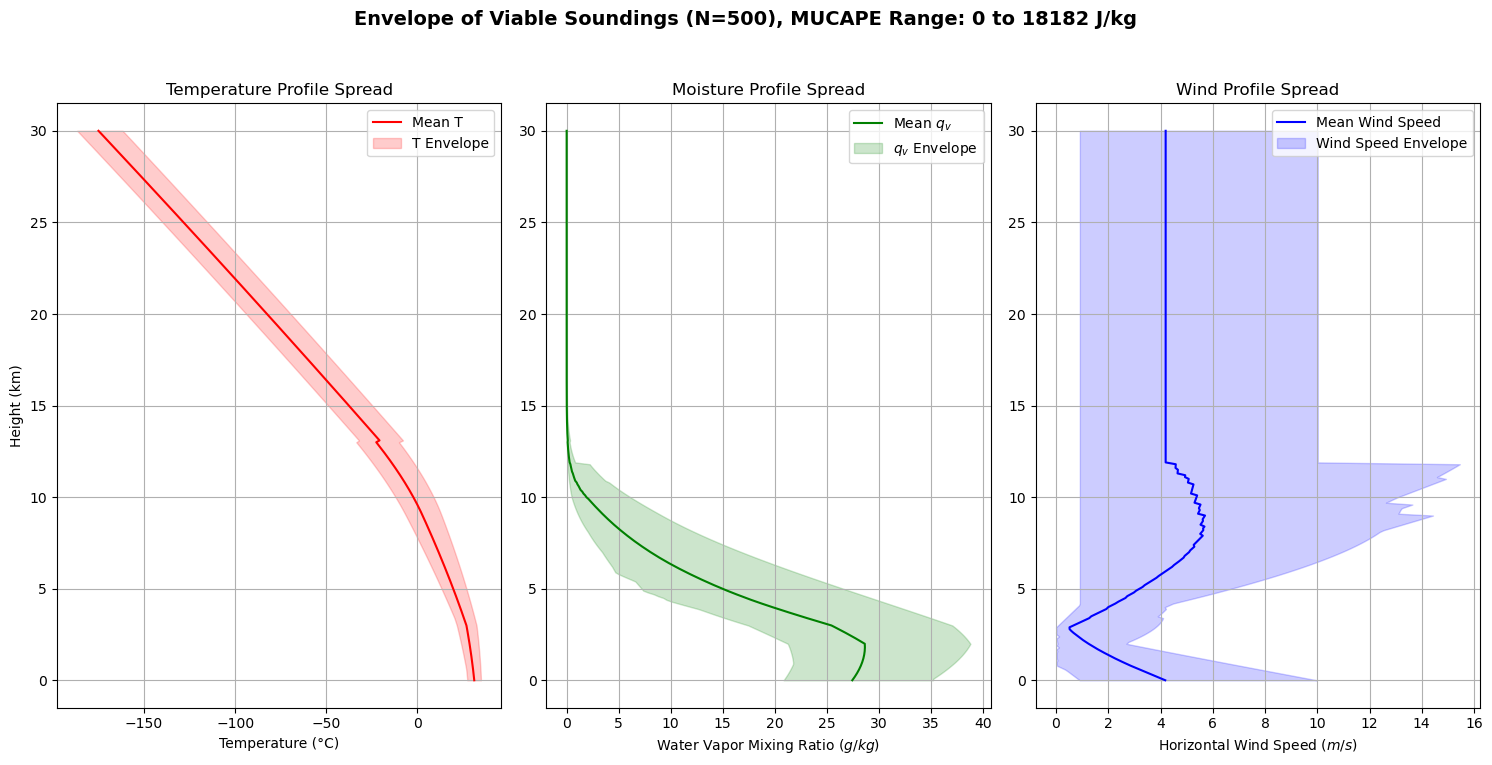

In [29]:
# --- PLOT ENVELOPE ---
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
height_km = all_heights / 1000.0

# 1. Temperature Profile Envelope
ax0 = axes[0]
ax0.plot(t_mean_c, height_km, 'r-', label='Mean T')
ax0.fill_betweenx(height_km, t_min_c, t_max_c, color='r', alpha=0.2, label='T Envelope')
ax0.set_xlabel('Temperature (°C)')
ax0.set_ylabel('Height (km)')
ax0.set_title('Temperature Profile Spread')
ax0.grid(True)
ax0.legend()

# 2. Moisture Profile Envelope (Mixing Ratio)
ax1 = axes[1]
ax1.plot(qv_mean, height_km, 'g-', label='Mean $q_v$')
ax1.fill_betweenx(height_km, qv_min, qv_max, color='g', alpha=0.2, label='$q_v$ Envelope')
ax1.set_xlabel('Water Vapor Mixing Ratio ($g/kg$)')
ax1.set_title('Moisture Profile Spread')
ax1.grid(True)
ax1.legend()

# 3. Wind Speed (Magnitude) Envelope - Shear Profile
# Calculate wind speed magnitude for min/max lines
wind_speed_mag = np.sqrt(all_u**2 + all_v**2)
ws_min, ws_max, ws_mean = wind_speed_mag.min(axis=0), wind_speed_mag.max(axis=0), wind_speed_mag.mean(axis=0)

ax2 = axes[2]
ax2.plot(ws_mean, height_km, 'b-', label='Mean Wind Speed')
ax2.fill_betweenx(height_km, ws_min, ws_max, color='b', alpha=0.2, label='Wind Speed Envelope')
ax2.set_xlabel('Horizontal Wind Speed ($m/s$)')
ax2.set_title('Wind Profile Spread')
ax2.grid(True)
ax2.legend()

fig.suptitle(f'Envelope of Viable Soundings (N={len(viable_indices)}), MUCAPE Range: {np.min(viable_mucape):.0f} to {np.max(viable_mucape):.0f} J/kg', 
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
def read_input_sounding(path):
    arr = np.loadtxt(path, comments='#', skiprows=1)
    p, T, qv, u, v, z = arr.T
    return dict(p=p, t=T, qv=qv, u=u, v=v, height=z)



In [ ]:
base=read_input_sounding(BASE_SOUNDING)
pb,tb,qvb,ub,vb,zb

ValueError: too many values to unpack (expected 6)

NameError: name 'zb' is not defined

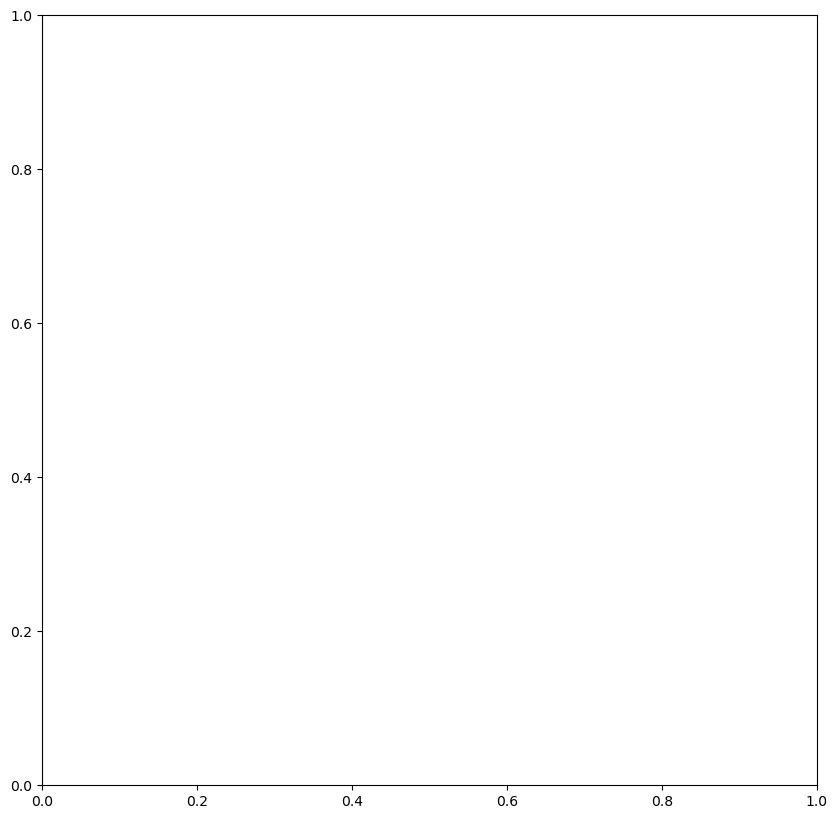

In [9]:
from metpy.plots import Hodograph

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
z_km = zb.to('km')


h = Hodograph(axs, component_range=22.)

h.add_grid(increment=10, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=5, ls='--', lw=1, alpha=0.2)
h.ax.scatter(ub, vb, c=zb,cmap='Spectral_r')
for i in range(len(u_arr)):
    h.ax.scatter(u_arr[i,:], v_arr[i,:], c=zb,cmap='Spectral_r',alpha=0.3)


ticks = np.arange(-20,21,5)

h.ax.set_xticks(ticks)
h.ax.set_yticks(ticks)
h.ax.set_yticklabels([str(t) for t in ticks])
h.ax.set_xticklabels([str(t) for t in ticks])
h.ax.set_xlabel('U (m/s)',weight='bold')
h.ax.set_ylabel('V (m/s)',weight='bold')
h.ax.set_box_aspect(1)

for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels',
                    clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels',
                    clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)


In [10]:
import matplotlib.pyplot as plt
from metpy.plots import SkewT, Hodograph
import metpy.calc as mpcalc
from metpy.units import units

# Variables globales para guardar referencias a objetos gráficos
lines_skew = []
barbs = None
cape_shade = None
cin_shade = None
lines_hodo = []
colorbar_hodo = None
scatter_hodo = None

def prepare_skewt_hodograph():
    #SKEWT
    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(12, 8))

    # Grid for plots
    skew = SkewT(fig, rotation=45, rect=(0.05,0.05,0.50,0.90))

    #add labels
    skew.ax.set_xlabel('Temperature (°C)',weight='bold')
    skew.ax.set_ylabel('Pressure (hPa)',weight='bold')

    # Set the limits of the plot
    skew.ax.set_xlim(-20, 40)
    skew.ax.set_ylim(1050, 100)

    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidths=0.8)
    skew.plot_moist_adiabats(linewidths=0.8)
    skew.plot_mixing_lines(linewidths=0.8)
    
    #HODOGRAPH
    ax_h = fig.add_axes([0.54,0.67,0.28,0.28])
    h = Hodograph(ax_h, component_range=15)
    h.add_grid(increment = 5)

    ticks = np.arange(-15,20,5)
    h.ax.set_yticklabels([str(t) for t in ticks])
    h.ax.set_xticklabels([str(t) for t in ticks])
    h.ax.set_xticks(ticks)
    h.ax.set_yticks(ticks)
    h.ax.set_xlabel('U (m/s)',weight='bold')
    h.ax.set_ylabel('V (m/s)',weight='bold')
    h.ax.set_box_aspect(1)

    for i in range(10, 120, 10):
       h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels',
                     clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
    for i in range(10, 120, 10):
       h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels',
                     clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)

    #TEXT BOX
    ax_indices = fig.add_axes([0.345, 0.11, 0.5, 0.5])
    ax_indices.axis('off')  #no axis

    return fig, skew, h, ax_indices

def plot_sounding(fig, skew, h, ax_indices, my_data , alpha=1,show=False, return_artists = False )  :
    global barbs, cape_shade, cin_shade

    p=my_data['p'] * units.hPa
    t=my_data['t'] * units.kelvin
    t = t.to('degC')
    z=my_data['height'] * units.meter
    u=my_data['u'] * units.meter / units.second
    v=my_data['v'] * units.meter / units.second
    qv = my_data['qv'] / 1000 * units('kg/kg')
    td = mpcalc.dewpoint_from_specific_humidity(p,qv)
    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot

    lt = skew.plot(p , t , 'r',alpha=alpha) [0]
    ltd = skew.plot(p , td , 'g',alpha=alpha) [0]
    
    # Barbas (guardar referencia para borrar luego)
    mask = p >= 100 * units.hPa
    if barbs is not None:
        try:
            barbs.remove()
        except:
            pass
    barbs = skew.plot_barbs(p[mask][::5],u[mask][::5],v[mask][::5],alpha=alpha)

    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0] , t[0] , td[0]  )
    lcl_dot = skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black',alpha=alpha) [0]

    # Calculate full parcel profile and add to plot as black line
    prof = mpcalc.parcel_profile(p , t[0] , td[0] ).to('degC')
    prof_line = skew.plot(p, prof, 'k', linewidth=2,alpha=alpha) [0]

    lines_skew.extend([lt,ltd, prof_line, lcl_dot])

    # Shade areas of CAPE and CIN
    #cape_shade = skew.shade_cin(p,t,prof,alpha=0.3)
    #cin_shade = skew.shade_cape(p,t,prof,alpha=0.3)

    # Create a hodograph
    z_km = z.to('km')
    idx = np.argmin(np.abs(z_km.m - 10)) #index for 10km

    #Scatterplot by color
    points = h.ax.scatter(u[0:idx+1].m, v[0:idx+1].m, c=z_km[0:idx+1].m, cmap='gist_ncar', s=15)

    #Calculate indices
    # most unstable parcel properties!
    mucape, mucin = mpcalc.most_unstable_cape_cin(p, t, td, depth=50 * units.hPa)

    # Compute Surface-based CAPE
    sbcape, sbcin = mpcalc.surface_based_cape_cin(p, t, td)

    #Calculo LFC
    lfc = mpcalc.lfc(p, t, td)   #[0] es el nivel de presión y [1] es la temperatura

    # Copmute Bulk Shear components and then magnitude
    ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
    bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
    ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
    bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
    ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
    bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)


    ax_indices.text(0.48, 0.95,f"   MUCAPE: {mucape.to('J/kg').m:.0f} J/kg        \n\n\n\n\n\n\n\n\n\n" , color = 'crimson',weight='bold',verticalalignment='top', fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='palegoldenrod', edgecolor='white', alpha=1))
    ax_indices.text(0.48, 0.895,f"   SBCAPE: {sbcape.to('J/kg').m:.0f} J/kg\n", color = 'crimson',weight='bold',verticalalignment='top', fontsize=12)
    ax_indices.text(0.48, 0.835,f"   MUCIN: {mucin.to('J/kg').m:.0f} J/kg\n" , color = 'blue',weight='bold',verticalalignment='top', fontsize=12)
    ax_indices.text(0.48, 0.775,f"   SBCIN: {sbcin.to('J/kg').m:.0f} J/kg\n" , color = 'blue',weight='bold',verticalalignment='top', fontsize=12)
    ax_indices.text(0.48, 0.715, f"   LFC: {lfc[0].m:.0f} hPa / {lfc[1].m:.1f} °C\n" ,color = 'black', weight='bold',verticalalignment='top', fontsize=12)
    ax_indices.text(0.48, 0.655,rf"   $\bf{{S}}_{{3}}$: {ubshr1.to('m/s').m:.0f} m/s" , color = 'green',weight='bold',verticalalignment='top', fontsize=12)
    ax_indices.text(0.48, 0.595,rf"   $\bf{{S}}_{{3}}$: {ubshr3.to('m/s').m:.0f} m/s", color = 'green',weight='bold',verticalalignment='top', fontsize=12)
    ax_indices.text(0.48, 0.535,rf"   $\bf{{S}}_{{6}}$: {ubshr6.to('m/s').m:.0f} m/s", color = 'green',weight='bold',verticalalignment='top', fontsize=12)

    if show:
        plt.show()

    if return_artists:
        return lines_skew, barbs, cape_shade, cin_shade, points
    else:
        return None




TypeError: 'NoneType' object is not subscriptable

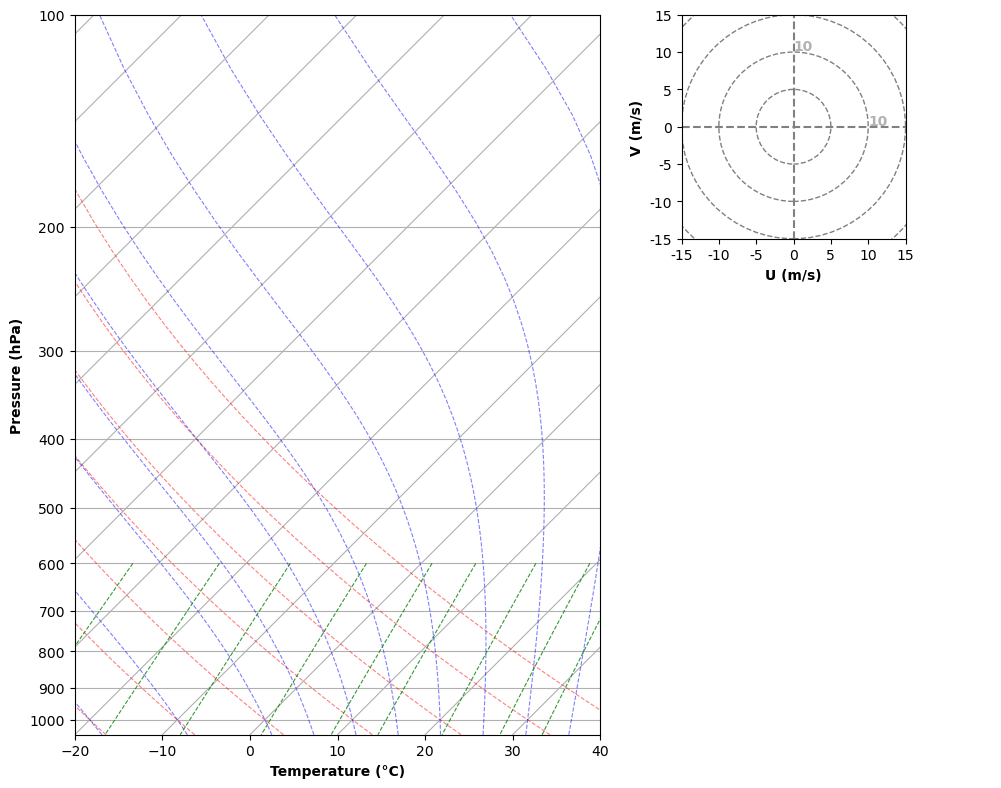

In [11]:
fig, skew, h, ax_indices = prepare_skewt_hodograph()
plot_sounding(fig, skew, h, ax_indices,base,show=False)
skew.shade_area(p , T_min-273.15,T_max-273.15 , which='negative', color='r',alpha=0.1)
skew.shade_area(p , Td_min-273.15,Td_max-273.15, which='both', color='g',alpha=0.1)
plt.show()